# Appendix 10.2.3: The complete tool use workflow

## Learning goals

* Understand the entire tool use workflow
* Write properly structured `tool_result` messages
* Implement a chatbot that utilizes tool use

In this lesson, we're going to implement the "full" 4-step tool use workflow we covered earlier.  So far, we've seen that Claude has used tools, but we haven't sent follow up requests to Claude that contain the result of our tool functionality.  Here's a recap of the full 4-step process: 

1. **Provide Claude with tools and a user prompt:** (API request)
    * Define the set of tools you want Claude to have access to, including their names, descriptions, and input schemas.
    * Provide a user prompt that may require the use of one or more of these tools to answer, such as "How many shares of General Motors can I buy with $500?"

2. **Claude uses a tool:** (API response)
    * Claude assesses the user prompt and decides whether any of the available tools would help with the user's query or task. If so, it also decides which tool(s) to use and with what input(s).
    * Claude outputs a properly formatted tool use request.
    * The API response will have a `stop_reason` of `tool_use`, indicating that Claude wants to use an external tool.

3. **Extract tool input(s), run code, and return results:** (API request)
    * On the client side, you should extract the tool name and input from Claude's tool use request.
    * Run the actual tool code on the client side.
    * Return the results to Claude by continuing the conversation with a new user message containing a `tool_result` content block.

4. **Claude uses the tool result to formulate a response:** (API response)
    * After receiving the tool results, Claude will use that information to formulate its final response to the original user prompt.

In this lesson, we'll go through the entire process. 

Here's a diagram with a general overview of the process:

![tool_use_flow.png](./images/tool_use_flow.png)

Here's a diagram explaining how our script will work: 

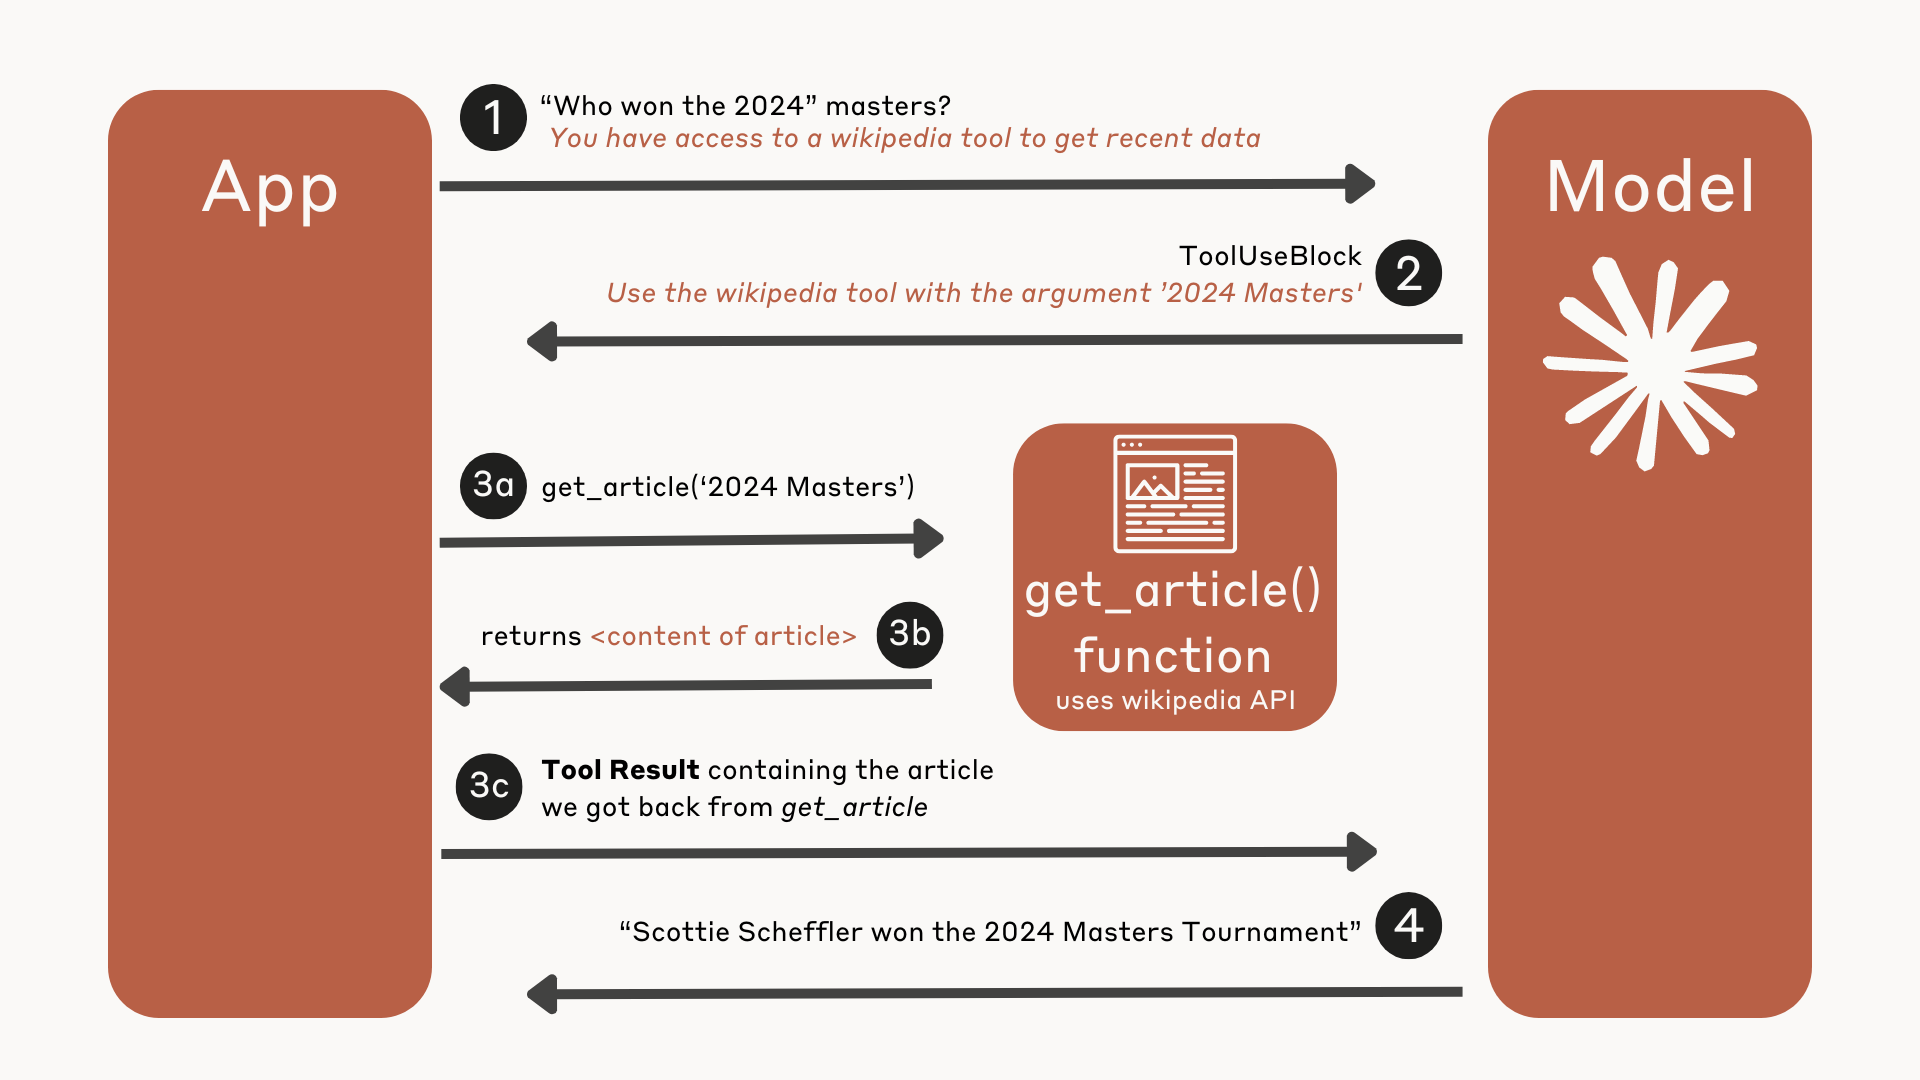


Here are some real exchanges that illustrate the end result we're hoping to achieve: 

> **User**: As of 2024 who has more oscars, Christopher Nolan or Ben Stiller?

> *Claude wants to get an article for Christopher Nolan* (tool use)

> *Claude wants to get an article for Ben Stiller* (tool use)

> **Claude**: As of 2024, filmmaker Christopher Nolan has won 2 Academy Awards for Best Director and Best Picture for his 2023 film Oppenheimer. On the other hand, actor and comedian Ben Stiller has not won any Oscars in his career so far, although he has won other awards like Emmys and MTV Movie Awards. So to directly answer the question, as of 2024, Christopher Nolan has won more Oscars (2) than Ben Stiller, who has not won any.

Here's another example:

> **User:** Who won the 2024 Masters Tournament?

> *Claude wants to get an article for 2024 Masters Tournament*  (tool use)

> **Claude:** Scottie Scheffler won the 2024 Masters Tournament, his second Masters victory. He finished four strokes ahead of runner-up Ludvig Åberg, who was making his debut at the Masters.

If we ask Claude a question that it can answer without needing to use our tool, it should just answer immediately without using our Wikipedia search tool:

> **User:** Who won the 2021 Masters?

> **Claude:** Hideki Matsuyama won the 2021 Masters Tournament, becoming the first Japanese man to win a major golf championship. He finished with a score of 278 (-10) to claim the green jacket at Augusta National Golf Club.



Here's a look at what the `messages` list looks like by the end of this process:

![messages_diagram.png](./images/br_messages_diagram.png)

The main new topic in this lesson is how to properly format our `tool_result` user message when responding to Claude's `tool_use` message.

## Building the complete workflow

### 1. Defining our Wikipedia search function

Before we do anything with Claude, let's write a simple function to search Wikipedia.  The following function uses the `wikipedia` package to search for matching wikipedia pages based on a search term.  To keep things simple, we take the first returned page title and then use that to access the corresponding page content.

Note: this simple function assumes we find a Wikipedia article. To keep things brief, the function has no error handling which is not a great idea in the real world!

In [ ]:
import boto3
import json
from datetime import datetime
from botocore.exceptions import ClientError

# Import the hints module from the utils package
from utils import hints

session = boto3.Session()
region = session.region_name

bedrock_client = boto3.client(service_name = 'bedrock-runtime', region_name = region,)

In [ ]:
import wikipedia

def get_article(search_term):
    results = wikipedia.search(search_term)
    first_result = results[0]
    page = wikipedia.page(first_result, auto_suggest=False)
    return page.content

In [ ]:
article = get_article("Superman")
print(article[:500]) # article is very long, so let's just print a preview

In [ ]:
article = get_article("Zendaya")
print(article[:500]) # article is very long, so let's just print a preview

### 2. Writing the tool definition
Next up, we need to define our tool using the proper JSON Schema format.  This is a very simple tool definition because the function expects a single argument: the search term string.  

In [ ]:
toolConfig = {
  "tools": [
    {
      "toolSpec": {
        "name": "get_article",
        "description": "A tool to retrieve an up to date Wikipedia article.",
        "inputSchema": {
          "json": {
            "type": "object",
            "properties": {
              "search_term": {
                "type": "string",
                "description": "The search term to find a wikipedia article by title"
              }
            },
            "required": ["search_term"]
          }
        }
      }
    }
  ]
}

### 3. Provide Claude with the tool and user prompt

Next, we'll tell Claude it has access to the Wikipedia search tool and ask it to answer a question we know it cannot answer without the tool, like "Who won the 2024 Masters Tournament?"

In [ ]:
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
messages = [{"role": "user", "content": [{"text": "who won the 2024 Masters Tournament?"}]}]

converse_api_params = {
    "modelId": modelId,
    "messages": messages,
    "inferenceConfig": {"temperature": 0.0, "maxTokens": 4096},
    "toolConfig": toolConfig
}

response = bedrock_client.converse(**converse_api_params)

### 4. Claude uses the tool (API response)

Let's look at the response we got back.  Claude wants to use our tool!

In [ ]:
response['output']['message']['content']

Claude's response contains 2 blocks: 

* A `text` value with the text "Okay, let me use the available tool to try and find information on who won the 2024 Masters Tournament on Wikipedia:"

```
[{'text': 'Okay, let me search Wikipedia for information on the 2024 Masters Tournament winner:'},
 {'toolUse': {'toolUseId': 'tooluse_8kC2QECHRYePqW0BS96_9Q',
   'name': 'get_article',
   'input': {'search_term': '2024 Masters Tournament'}}}]
```

* A `toolUse` value calling our `get_article` tool with the `search_term` "2024 Masters Tournament"

```
{'toolUse': {'toolUseId': 'tooluse_8kC2QECHRYePqW0BS96_9Q',
   'name': 'get_article',
   'input': {'search_term': '2024 Masters Tournament'}}}
```


### 5. Extract tool input(s), run code, and return results (API request)

Now that Claude has responded telling us it wants to use a tool, it's time for us to actually run the underlying functionality AND respond back to Claude with the corresponding Wikipedia page content.

**We need to pay special attention to make sure we update our `messages` list**

We'll begin by updating our `messages` list to include Claude's most recent response:

In [ ]:
messages.append({"role": "assistant", "content": response['output']['message']['content']})

In [ ]:
messages

Next, we'll extract the specific tool and arguments that Claude wants to use:

In [ ]:
# This is a simple, but brittle way of getting the tool use information
# We're simply taking the last block from Claude's response.
tool_use = response['output']['message']['content'][-1]
tool_id = tool_use['toolUse']['toolUseId']
tool_name = tool_use['toolUse']['name']
tool_inputs = tool_use['toolUse']['input']

print("Tool Id: ", tool_id)
print("Tool name: ", tool_name)
print("Tool input", tool_inputs)

Next, we'll make sure Claude is calling the `get_article` tool we're expecting.  We'll take the `search_term` Claude came up with and pass that to the `get_article` function we wrote earlier.

In [ ]:
if tool_name == "get_article":
    search_term = tool_inputs["search_term"]
    wiki_result = get_article(search_term)
    print(f"Searching Wikipedia for: {search_term}")
    print("WIKIPEDIA PAGE CONTENT:")
    print(wiki_result[:500]) #just printing a small bit of the article because it's so long

Now that we've executed the function Claude wanted us to call, it's time to respond back to Claude with the Wikipedia page data.

As we know, when Claude wants to use a tool, it responds to us with a `stop_reason` of `tool_use` and one or more `tool_use` content blocks in the API response that include:
* `id`: A unique identifier for this particular tool use block. This will be used to match up the tool results later.
* `name`: The name of the tool being used.
* `input`: An object containing the input being passed to the tool, conforming to the tool's `input_schema`.

Once we have executed our underlying tool function, we need to respond back to Claude with a particular format as well. Specifically, to continue the conversation, we need to send a new message with the **role of `user`** and a content block **containing the `tool_result` type**, along with the following information:
* `toolUseId`: The id of the tool use request this is a result for.
* `content`: The result of the tool, as a string (e.g. "content": "15 degrees") or list of nested content blocks (e.g. "content": [{"type": "text", "text": "15 degrees"}]\). 
* `status` (optional): Set to **success** or **error** based on the tool execution results.

Here's an example of what a properly formatted `toolResult` message looks like: 

```json
{
    "role": "user",
    "content": [
        {
            "toolResult": {
                "toolUseId": "tooluse_kZJMlvQmRJ6eAyJE5GIl7Q",
                "content": [
                    {
                        "json": {
                            "song": "Elemental Hotel",
                            "artist": "8 Storey Hike"
                        }
                    }
                ]
            }
        }
    ]
}
```

Let's do this now for our Wikipedia search example. We need to form a properly constructed tool response message to send our Wikipedia search result back to Claude:

In [ ]:
tool_response = {
    "role": "user",
    "content": [
        {
            "toolResult": {
                "toolUseId": tool_id,
                "content": [
                    {
                        "text": wiki_result
                        }
                ]
            }
        }
    ]
}

In [ ]:
# Notice the long wikipedia article content!
tool_response

Next, we need to add our `tool_response` message to our messages list: 

In [ ]:
messages.append(tool_response)

In [ ]:
messages

Our `messages` list now looks like this: 

* User: Who won the 2024 Masters Tournament?
* Assistant: I want to use the `get_article` tool with `search_term` "2024 Masters Tournament"
* User: Here's the tool result that contains the Wikipedia article you asked for

Here's a diagram that illustrates this.

![wiki_messages.png](./images/br_wiki_messages.png)

Note that the initial `id` matches the `tool_use_id` in our follow up user message


### 6. Claude uses the tool result to formulate a response: (API response)

Finally, we can use our updated `messages` list and send a new request to Claude:

In [ ]:
converse_api_params = {
    "modelId": modelId,
    "messages": messages,
    "inferenceConfig": {"temperature": 0.0, "maxTokens": 1000},
    "toolConfig": toolConfig #The toolConfig which contains our article_search_tool details
}

follow_up_response = bedrock_client.converse(**converse_api_params)

In [ ]:
follow_up_response['output']['message']['content'][0]['text']

Claude now has the information needed to answer the initial question and responds back with:

> 'According to the information provided, Scottie Scheffler won the 2024 Masters Tournament.According to the information provided, Scottie Scheffler won the 2024 Masters Tournament...'

We have now completed all 4 steps of the process! 

***

## Improving the code

At a bare minimum, we probably want to put all the above code into a reusable function so we can try it out a few times:

In [ ]:
def answer_question(question):
    messages = [{"role": "user", "content": [{"text": question}]}]

    converse_api_params = {
        "modelId": modelId,
        "messages": messages,
        "inferenceConfig": {"temperature": 0.0, "maxTokens": 4096},
        "toolConfig": toolConfig #The toolConfig which contains our article_search_tool details
    }

    response = bedrock_client.converse(**converse_api_params)

    if(response['stopReason'] == "tool_use"):
        tool_use = response['output']['message']['content'][-1]
        tool_id = tool_use['toolUse']['toolUseId']
        tool_name = tool_use['toolUse']['name']
        tool_inputs = tool_use['toolUse']['input']
        #Add Claude's tool use call to messages:
        messages.append({"role": "assistant", "content": response['output']['message']['content']})

        if tool_name == "get_article":
            search_term = tool_inputs["search_term"]
            print(f"Claude wants to get an article for: {search_term}")
            wiki_result = get_article(search_term) #get wikipedia article content
            #construct our tool_result message
            tool_response = {
                "role": "user",
                "content": [
                    {
                        "toolResult": {
                            "toolUseId": tool_id,
                            "content": [
                                {"text": wiki_result}
                            ]
                        }
                    }
                ]
            }
            messages.append(tool_response)
            #respond back to Claude
            converse_api_params = {
                "modelId": modelId,
                "messages": messages,
                "inferenceConfig": {"temperature": 0.0, "maxTokens": 4096},
                "toolConfig": toolConfig  #The toolConfig which contains our article_search_tool details
            }

            response = bedrock_client.converse(**converse_api_params)

            print("Claude's final answer:")
            print(response['output']['message']['content'][0]['text'])

    else:
        print("Claude did not call our tool")
        print(response['output']['message']['content'][0]['text'])

In [ ]:
answer_question("Who won the 2024 F1 Australian Grand Prix")

In [ ]:
answer_question("Who stars in the movie Challengers?")

In [ ]:
#Let's try an example that Claude should NOT need our tool to answer:
answer_question("Who wrote the book 'The Life of Pi'")

Notice that Claude called our Wikipedia tool to help answer this last question, even though Claude already knows the answer.  "Life of Pi" was published in 2001, long before Claude's training cutoff!

***

## Improving our prompt

As we saw in a previous lesson, sometimes Claude is overly eager to use tools.  An easy wasy to fix this is through the system prompt.


We could add a system prompt that looks something like this:

In [ ]:
system_prompt = """
    You will be asked a question by the user. 
    If answering the question requires data you were not trained on, you can use the get_article tool to get the contents of a recent wikipedia article about the topic. 
    If you can answer the question without needing to get more information, please do so. 
    Only call the tool when needed. 
    """

Let's update our function to use this new system prompt:

In [ ]:
def answer_question(question):
    system_prompt = """
    You will be asked a question by the user. 
    If answering the question requires data you were not trained on, you must use the get_article tool to get the contents of a recent wikipedia article about the topic. 
    If you can answer the question without needing to get more information, please do so. 
    Only call the tool when needed. 
    """
    messages = [{"role": "user", "content": [{"text": question}]}]

    converse_api_params = {
        "modelId": modelId,
        "system": [{"text": system_prompt}],
        "messages": messages,
        "inferenceConfig": {"temperature": 0.0, "maxTokens": 4096},
        "toolConfig": toolConfig  #The toolConfig which contains our article_search_tool details
    }

    response = bedrock_client.converse(**converse_api_params)

    if(response['stopReason'] == "tool_use"):
        tool_use = response['output']['message']['content'][-1]
        tool_id = tool_use['toolUse']['toolUseId']
        tool_name = tool_use['toolUse']['name']
        tool_inputs = tool_use['toolUse']['input']
        #Add Claude's tool use call to messages:
        messages.append({"role": "assistant", "content": response['output']['message']['content']})

        if tool_name == "get_article":
            search_term = tool_inputs["search_term"]
            print(f"Claude wants to get an article for: {search_term}")
            wiki_result = get_article(search_term) #get wikipedia article content
            #construct our tool_result message
            tool_response = {
                "role": "user",
                "content": [
                    {
                        "toolResult": {
                            "toolUseId": tool_id,
                            "content": [
                                {"text": wiki_result}
                            ]
                        }
                    }
                ]
            }
            messages.append(tool_response)
            #respond back to Claude
            converse_api_params = {
                "modelId": modelId,
                "system": [{"text": system_prompt}],
                "messages": messages,
                "inferenceConfig": {"temperature": 0.0, "maxTokens": 4096},
                "toolConfig": toolConfig  #The toolConfig which contains our article_search_tool details
            }

            response = bedrock_client.converse(**converse_api_params)

            print("Claude's final answer:")
            print(response['output']['message']['content'][0]['text'])

    else:
        print("Claude did not call our tool")
        print(response['output']['message']['content'][0]['text'])

Let's try asking the same question:

In [ ]:
answer_question("Who wrote the book The Life of Pi")

It worked! Claude did not use our tool when it wasn't needed.  Let's make sure it still works when answering questions that do require recent knowledge:

In [ ]:
answer_question("Who wrote the score for the movie Challengers?")

It's working as intended in both situations! Now let's work on getting Claude's response to be a little more succinct.  It's great that Claude is explaining HOW it came up with the correct answer, but it's a little verbose. Let's do a little basic prompt engineering to fix that.  

Let's try this:

In [ ]:
prompt = f"""
    Answer the following question <question>Who wrote the movie Poor Things?</question>
    When you can answer the question, keep your answer as short as possible and enclose it in <answer> tags
    """

Here's our function updated with the new prompt:

In [ ]:
def answer_question(question):
    system_prompt = """
    You will be asked a question by the user. 
    If answering the question requires data you were not trained on, you must use the get_article tool to get the contents of a recent wikipedia article about the topic. 
    If you can answer the question without needing to get more information, please do so. 
    Only call the tool when needed.
    """
    prompt = f"""
    Answer the following question <question>{question}</question>
    When you can answer the question, keep your answer as short as possible and enclose it in <answer> tags
    """
    messages = [{"role": "user", "content": [{"text": prompt}]}]

    converse_api_params = {
        "modelId": modelId,
        "system": [{"text": system_prompt}],
        "messages": messages,
        "additionalModelRequestFields": {"max_tokens": 4096},
        "toolConfig": toolConfig  #The toolConfig which contains our article_search_tool details
    }

    response = bedrock_client.converse(**converse_api_params)

    if(response['stopReason'] == "tool_use"):
        tool_use = response['output']['message']['content'][-1]
        tool_id = tool_use['toolUse']['toolUseId']
        tool_name = tool_use['toolUse']['name']
        tool_inputs = tool_use['toolUse']['input']
        #Add Claude's tool use call to messages:
        messages.append({"role": "assistant", "content": response['output']['message']['content']})

        if tool_name == "get_article":
            search_term = tool_inputs["search_term"]
            print(f"Claude wants to get an article for: {search_term}")
            wiki_result = get_article(search_term) #get wikipedia article content
            #construct our tool_result message
            tool_response = {
                "role": "user",
                "content": [
                    {
                        "toolResult": {
                            "toolUseId": tool_id,
                            "content": [
                                {"text": wiki_result}
                            ]
                        }
                    }
                ]
            }
            messages.append(tool_response)
            #respond back to Claude
            converse_api_params = {
                "modelId": "anthropic.claude-3-sonnet-20240229-v1:0",
                "system": [{"text": system_prompt}],
                "messages": messages,
                "additionalModelRequestFields": {"max_tokens": 4096},
                "toolConfig": toolConfig  #The toolConfig which contains our article_search_tool details
            }

            response = bedrock_client.converse(**converse_api_params)

            print("Claude's final answer:")
            print(response['output']['message']['content'][0]['text'])

    else:
        print("Claude did not call our tool")
        print(response['output']['message']['content'][0]['text'])

In [ ]:
answer_question("Who wrote the score for the film Challengers?")

In [ ]:
answer_question("Who won the 2024 F1 Australian Grand Prix?")

In [ ]:
answer_question("How many legs does an octopus have?")

Much better! Claude is now responding with answers without a bunch of additional "thinking" and explanation about how it arrived at the answer.

***

## Exercise

Can you update this code so that it fulfills the following requirements:
* Claude might not get enough information from the first Wikipedia page we respond with.  We haven't handled that situation yet.  Imagine we ask Claude "How many Oscars does Christopher Nolan have?  Does he have more than the number of Emmy's that Ben Stiller has?"  Claude would need to search Christopher Nolan's Wikipedia page AND Ben Stiller's page, likely one after another.  Our code currently does not allow this, so let's build in that functionality! **Hint: use a loop!**  
* Extract the answer from the `<answer></answer>` tags Claude currently responds with so that you only print out the actual answer content.
* Can you turn this into a full command-line chatbot that continuously asks a user to enter a query and then responds with the answer over and over until a user quits the program? The output could look something like this: 



Here's a screenshot of an example conversation session: 

![exercise_conversation.png](./images/exercise_conversation.png)